# Clusterización: Extracción de Colores Predominantes en Imágenes
### Itzanami Berlanga Contreras | 07 de Abril del 2024

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd
from skimage import io

## Carga de la Imagenes

[[[0.75686275 0.43529412 0.29019608]
  [0.77647059 0.45490196 0.30980392]
  [0.76470588 0.44313725 0.29803922]
  ...
  [0.57254902 0.30588235 0.21568627]
  [0.57254902 0.30588235 0.21568627]
  [0.57254902 0.30588235 0.21568627]]

 [[0.76862745 0.44705882 0.30196078]
  [0.77254902 0.45098039 0.30588235]
  [0.76078431 0.43921569 0.29411765]
  ...
  [0.58039216 0.31372549 0.22352941]
  [0.58039216 0.31372549 0.22352941]
  [0.58039216 0.31372549 0.22352941]]

 [[0.78039216 0.45098039 0.30588235]
  [0.75294118 0.41960784 0.29803922]
  [0.78431373 0.45882353 0.30196078]
  ...
  [0.58823529 0.31372549 0.21176471]
  [0.57647059 0.31372549 0.21176471]
  [0.56862745 0.30980392 0.21568627]]

 ...

 [[0.65882353 0.34509804 0.23921569]
  [0.66666667 0.35294118 0.24705882]
  [0.68235294 0.37254902 0.25490196]
  ...
  [0.27058824 0.15294118 0.14509804]
  [0.27058824 0.14901961 0.14117647]
  [0.27843137 0.15686275 0.14901961]]

 [[0.65098039 0.3372549  0.23921569]
  [0.6627451  0.34901961 0.24313725]


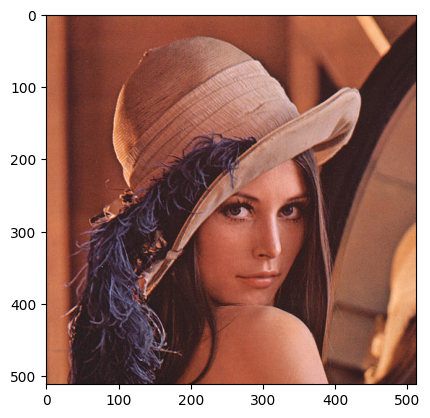

In [3]:
image=io.imread("lena_color.bmp")/255.0  # imread lee las imagenes con los pixeles codificados como enteros, dividimos entre 255 para escalarlos de 0 a 1

# Como en este caso solo nos interesa la diferencia en el color y no las coordenadas del pixel, convertimos la matriz en un arreglo de colores:
color_array = np.asarray(image)
print(color_array)
print("- Dimensiones de la imagen:")
print(image.shape)
plt.imshow(image)

In [36]:
aux = [[4, 3], [2, 5], [1, 3]]
aux2 = [1, 4, 3]
aux3 = (np.array(aux2) * np.array(aux).T).T  
aux4 = aux3.sum(axis=0)
aux5 = np.sum(aux4)
aux6 = np.divide(aux4, aux5)
print(aux3)
print(aux4)
print(aux6)


[[ 4  3]
 [ 8 20]
 [ 3  9]]
[15 32]
[0.31914894 0.68085106]


## Gaussian Mixture Model

El algoritmo funciona de la siguiente manera

Expectation Step
Distribución Normal
$$\mathcal{N} (\mathbf{x} | \mu, \Sigma) = \frac{1}{(2\pi)^{D/2} |\Sigma|^{1/2}}\exp\left( -\frac{1}{2}(\mathbf{x} - \mu)^{T} \Sigma^{-1}(\mathbf{x} - \mu)\right)$$


In [10]:
class GMM:
    def __init__(self, k_clusters = 3, epochs = 200):
        self.k = k_clusters
        self.means = None
        self.cov = None
        self.mix_prob = None
        self.epochs = epochs
        self.dim = None
        
    def cluster(self, X):
        self.dim = X[0].shape
        # Inicializamos las medias random, las inicializamos entre 0-1 que es donde se encuentran nuestros valores
        self.means = np.random.random((self.k, self.dim))
        # Al inicio inicializamos las probabilidades iguales para todos los clusters
        self.mix_prob = np.ones(len(self.k))/self.k          
        # Matriz de covarianzas
        aux = np.random.rand(self.k, self.k)
        self.cov = np.tril(aux) + np.tril(aux, -1).T
        for i in range(self.epochs):
            # E-step
            # Calcular las responsabilidades gamma usando los parámetros actuales
            gamma = np.zeros((self.dim, self.k))
            for j in range(len(X)):
                gamma[j] = self.__gamma(X[j])
            # M-step
            # Actualización de parámetros
            # Primero se actualizan las medias
            for j in range(self.k):
                mult = (np.array(gamma[:,j]) * np.array(X).T).T
                num = mult.sum(axis=0)
                #num = np.sum(np.multiply(gamma[ :,j], X))
                den = np.sum(gamma[:,j])
                self.means[j] = np.divide(num, den)
            # Después actualizamos la matriz de covarianza
            for j in range(self.k):
                resta = X - self.means[j]
                mult = np.array(gamma[:,j])*(resta*resta.T)
                num = mult.sum(axis=0)
                den = np.sum(gamma[:,j])
                self.cov[j] = np.divide(num, den)
            # Finalmente actualizamos las probabilidades de mezcla
            for j in range(self.k):
                self.mix_prob[j] = np.sum(gamma[:,j])/len(X)
            conv = 0
            for j in range(self.k):
                conv += self.mix_prob[j]*self.__gaussian_distribution(X, j)
        
    def __gamma(self, x):
        gd = np.zeros(self.k)
        for i in range(self.k):
            gd[i] = self.__gaussian_distribution(x, i)
        prod = np.multiply(gd, self.mix_prob)
        denom = np.sum(prod)
        return np.divide(gd, denom)
    
    def __gaussian_distribution(self, x, clust):
        exp_value = -1/2*np.matmul(np.matmul((x - self.means[clust]).T, np.linalg.inv(self.cov)), (x - self.means[clust]))
        gd = np.exp(exp_value) * 1/((2*self.mix_prob[clust])**(self.dim/2) * (np.linalg.det(self.cov))**0.5)
        return gd
        